In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

img_01 = cv2.imread('tsukuba/scene1.row3.col1.ppm')
img_01 = cv2.cvtColor(img_01,cv2.COLOR_BGR2RGB)
img_02 = cv2.imread('tsukuba/scene1.row3.col2.ppm')
img_0 = cv2.cvtColor(img_02,cv2.COLOR_BGR2RGB)
img_03 = cv2.imread('tsukuba/scene1.row3.col3.ppm')
img_03 = cv2.cvtColor(img_03,cv2.COLOR_BGR2RGB)
img_04 = cv2.imread('tsukuba/scene1.row3.col4.ppm')
img_04 = cv2.cvtColor(img_04,cv2.COLOR_BGR2RGB)
img_05 = cv2.imread('tsukuba/scene1.row3.col5.ppm')
img_05 = cv2.cvtColor(img_05,cv2.COLOR_BGR2RGB)
images = [img_01, img_02, img_03, img_04, img_05]

In [2]:
# OpenCV's own implementation

def gaussian_pyramid_images_cv(img):
    p_imgs = [img]
    for i in np.arange(3):
        img = cv2.pyrDown(img)
        p_imgs.append(img)
    return p_imgs

# Selfimplemented Gaussian Pyramid function.
# Convolves with a Gaussian kernel and then removes all even rows and columns.
# Output is four images at a higher pyramid level and therefore lower resolution. 

def gaussian_pyramid_images(img):
    p_imgs = [img]
    
    for i in np.arange(3):
        img = cv2.GaussianBlur(img, (5,5), 2)
        img_new = []
        for i in np.arange(1,img.shape[0],2):
            img_row = []
            for j in np.arange(1,img.shape[1],2):
                img_row.append(img[i][j])
            img_new.append(img_row)
            
        img = np.array(img_new)
        p_imgs.append(img)
        
    return p_imgs


In [3]:
def plot_images(imgs):
    i, j = len(imgs)//2, len(imgs)//2
    fig, ax = plt.subplots(i, j, figsize=(15,15))
    ii, jj = np.meshgrid(np.arange(i), np.arange(j), indexing='ij')
    axes = [axis for axis in zip(ii.ravel(), jj.ravel())]
    for idx, axis in enumerate(axes):
        ax[axis].imshow(imgs[idx], "gray")
    plt.show()

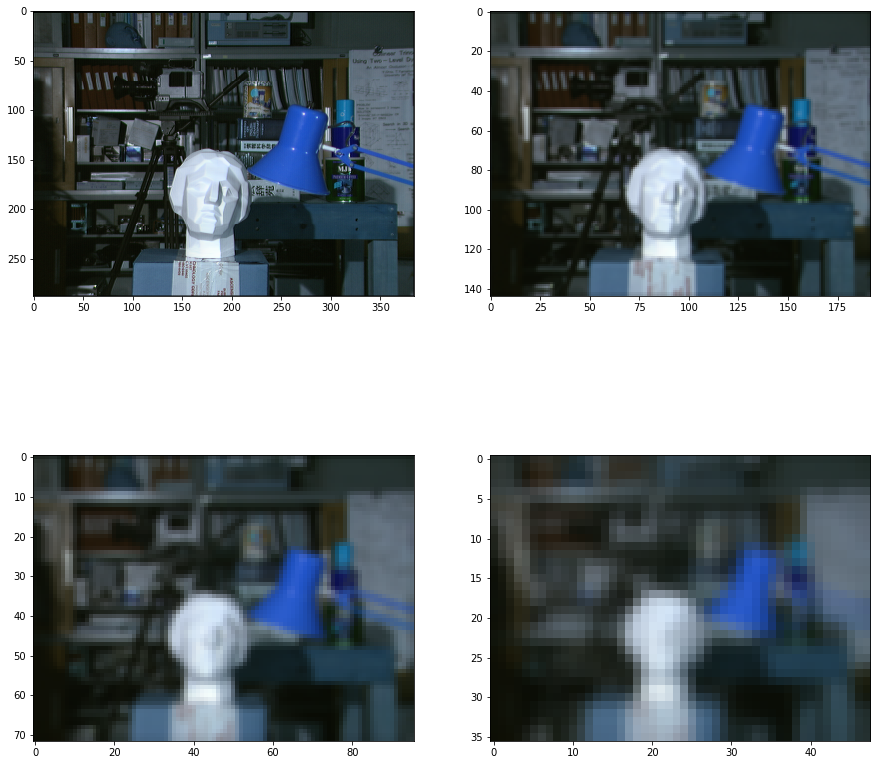

In [4]:
pyramid_images_img1 = gaussian_pyramid_images(img_01)
plot_images(pyramid_images_img1)

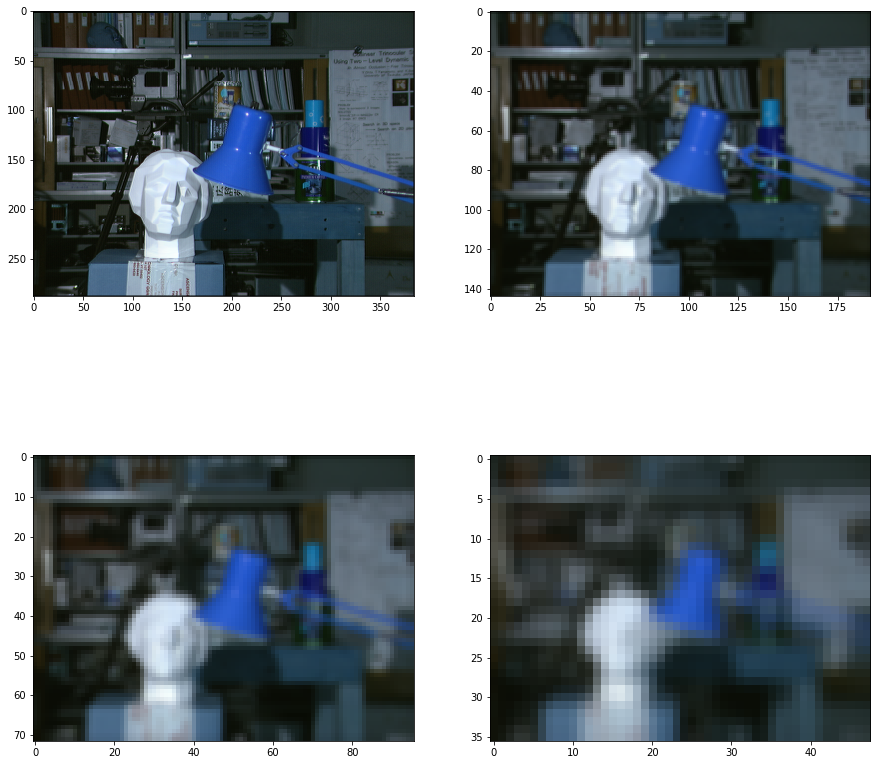

In [5]:
pyramid_images_img5 = gaussian_pyramid_images(img_05)
plot_images(pyramid_images_img5)

In [6]:

def create_patching_kernel(size):
    ii, jj = np.meshgrid(np.arange(-(size//2),size//2+1), np.arange(-(size//2),size//2+1), indexing='ij')
    return np.array([xy for xy in zip(jj.ravel(), ii.ravel())])

def create_image_grid(image):
    ii, jj = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]), indexing='ij')
    image_grid = []
    for i in np.arange(image.shape[0]):
        image_grid.append([ij for ij in zip(ii[i].ravel(), jj[i].ravel())])
    return np.array(image_grid)

def create_patch_grid(img1, img2, size, M):
    index, column = img1.shape[0], img2.shape[1]
    patch_grid_coords = create_patching_kernel(size)
    final_patch_grid = []
    
    for i in np.arange(index):
        patch_space = [row for row in np.arange(i-(size//2),i+(size//2+1)) if row >= 0 and row <= index-1]
        patched_pixel_row = []
        for j in np.arange(column):
            patch_coords = np.array([np.array([i,j])+ij for ij in patch_grid_coords])
            patch_coords_adj = patch_coords[((patch_coords >= 0).all(axis=1)) \
                                            & ((patch_coords < [index,column]).all(axis=1))]
            patched_pixel_row.append(patch_coords_adj)
        final_patch_grid.append(patched_pixel_row)
        
    return np.array(final_patch_grid)
            

In [ ]:
def pextract(img, y):
    patch = np.empty_like(patch0)
    patches = np.empty_like(patches0)
    for x in range(0, ish[1]):
        a = img[y:y+windowsize,x:x+windowsize,:]
        #normalized cross-correlation prep
        a=((a[:,:,0]+a[:,:,1]+a[:,:,2])/3).reshape(length)
        #a =(a[:,:,0]+a[:,:,1]+a[:,:,2])
        #a = a.reshape(length)
        #patch = a / np.std(a)
        patch = (a - np.mean(a)) / np.std(a)
        patches[x] = patch
    return patches

def hpatches(img1, img2, y):
    padded1= cv2.copyMakeBorder(img1,pad,pad,pad,pad,cv2.BORDER_CONSTANT)
    padded2= cv2.copyMakeBorder(img2,pad,pad,pad,pad,cv2.BORDER_CONSTANT)
    patches1 = pextract(padded1, y)
    patches2 = pextract(padded2, y)
    return patches1, patches2

def correspondence(img1,img2, wsize = 5):
    start = time.clock() 
    global windowsize
    windowsize = wsize
    global pad
    pad = (windowsize-1)//2
    global length
    length = windowsize**2
    global ish
    ish = img1.shape
    global psh
    psh = (img1.shape[0]+2*pad,img1.shape[1]+2*pad)
    global patch0
    patch0 = np.empty((windowsize,windowsize))
    global patches0
    patches0 = np.empty((psh[1]-windowsize+1, length))
    result = np.zeros((ish[0], ish[1]))
    result_nonsqrd = np.zeros((ish[0], ish[1]))
    for y in range(ish[0]):
        #print(y)
        patches1, patches2 = hpatches(img1, img2, y)
        for x in range(ish[1]):
            #normalized cross-correlation
            best = -999
            #pa = patches1[x]
            #a = pa / (np.std(pa) * len(pa))
            r = [0, patches2.shape[0]]
            rr = ish[1]//25 #limits search range
            if x - rr > 0:
                r[0] = x - rr
            if x + rr < ish[1]:
                r[1] = x + rr
            for h in range(r[0],r[1]):
                #b = patches2[h] / patches2[h]
                ncc = np.correlate(patches1[x]/length, patches2[h]) 
                if ncc > best:
                    best = ncc
                    besth =h
            result[y,x]=abs(x-besth)**2
            result_nonsqrd[y,x]=x-besth
            #print(best,ncc, x,y,h, besth)
    elapsed = time.clock()
    elapsed = elapsed - start
    print ("Done. Time spent executing correspondence: ", elapsed)
    return result, result_nonsqrd


In [ ]:
pyramid_images_imgcv1 = gaussian_pyramid_images_cv(img_01)
pyramid_images_imgcv2 = gaussian_pyramid_images_cv(img_02)
pyramid_images_img1 = gaussian_pyramid_images(img_01)
pyramid_images_img2 = gaussian_pyramid_images(img_02)

imgs_cv = []
for i in np.arange(4):
    imgs_cv.append(correspondence(pyramid_images_imgcv1[i], pyramid_images_imgcv2[i], 7)[0])

imgs = []
for i in np.arange(4):
    imgs.append(correspondence(pyramid_images_img1[i], pyramid_images_img2[i], 7)[0])

In [ ]:
plot_images(imgs_cv)

In [ ]:
plot_images(imgs)